# Paper title: Geometric properties of PalmTree instruction embeddings
## Target IJCNN, deadline: End of January


## **Overview**
*   Geometry of embeddings
*   Pairwise correlations
*   Find which are closer to which 
*   Analog relationship or outlier detection, see how embeddings relate different instructions
*   Analyze how effective basic block search is
*   Improve it by encoding pairs, or more instructions at a time
*   Do deep metric learning to improve distance matching/basic block search \

**Pairwise correlations** 
*   Correlations of the embeddings, plot them on histogram 
*   Relies on inner products between two vectors,

**Analyze** 
*   call, ret, mov, etc. most important instructions in malware analysis
*   Pick common instructions, look at embeddings see which ones are closer
*   Prediction "non of embeddings will be close/ will be perpendicular" 
*   Look at the vectors, for constants 0, 1, 2, etc. 

**Analog query** 
*   K nearest neighbors  
*   Look at vectors in  each layer, as input goes through, can see performance for analog query 
*   Find vector for king, minus vector for man + woman. find vector closest to this, see if result vector is close to king 
*   Outlier detection, look at each layer 

**Plot of embedding norms** 
*   Norm inverserly related to the frequency of tokens 
*   The most frequent tokens had smallest norm in Bert 

**For outliers, see accuracy of outliers from layer to layer**
*   Given sequence, see how it changes through the layers 
*   Look at number of layers in model 

**Basic Block Search** 
*   Do analysis, how effective the embeddings to characterize similiarities between basic blocks 
*   Average cosine distance used as similarity 

**Possible improvment**
*   Given a basic block, if encodes one instruction at time, then take average
*   Problem for instructions that are dependant on others
*   Figure out how to improve it, possible encod epair of instructions at a time

**Metric learning** "Deep Metric Learning to Rank"
*   If dataset is available, apply FastAP
*   See if it improves 







## Initialize Colab & Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install bert-pytorch
!pip install pytorch_metric_learning

In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks/PalmTree-Trained/

/content/drive/.shortcut-targets-by-id/1LMg3kN9NvUURy3zB07RjiMQNzN0TPyMm/PalmTree-Trained


## Import and Load PalmTree model

In [4]:
import os
from config import *
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
from torch.autograd import Variable
import torch
import numpy as np
import eval_utils as utils

import vocab
import pickle

palmtree = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")

# tokens has to be seperated by spaces.

text = ["mov rbp rdi", 
        "mov ebx 0x1", 
        "mov rdx rbx", 
        "call memcpy", 
        "mov [ rcx + rbx ] 0x0", 
        "mov rcx rax", 
        "mov r13 qword [ rax ]",
        "mov [ rax ] 0x2e"]

# it is better to make batches as large as possible.
embeddings = palmtree.encode(text)
#for i in range(7):
#  print("usable embedding of this basicblock:", np.corrcoef(embeddings))
print("usable embedding of this basicblock:", np.linalg.norm(embeddings))

print("the shape of output tensor: ", embeddings.shape)

Loading Vocab ./palmtree/vocab
Vocab Size:  6631
usable embedding of this basicblock: 75.063576
the shape of output tensor:  (8, 128)


## Test Vocabulary

In [5]:
#Test Vocabulary
vocab_path = "./palmtree/vocab"
with open(vocab_path, "rb") as file:
  data = file.read()
  tokens = pickle.loads(data)
num_of_tokens = len(tokens)
print(tokens.to_seq(sentence="retn rbp 0x1"))
print(tokens.from_seq(seq=[5, 14, 19], join=True))

print(tokens.from_seq(seq=list(range(0,num_of_tokens)), join=False))

[68, 14, 28]
mov rbp rdi
['<pad>', '<unk>', '<eos>', '<sos>', '<mask>', 'mov', '[', ']', 'rax', '+', 'qword', 'address', 'eax', 'rsp', 'rbp', 'rbx', 'symbol', 'rdx', 'call', 'rdi', '-', 'dword', 'add', 'rsi', 'rcx', 'cmp', 'je', '0x8', '0x1', 'test', 'edx', 'byte', 'r12', 'lea', 'jne', 'pop', '0x0', 'jmp', 'r13', 'r14', 'xor', 'r15', 'esi', 'ecx', 'edi', '0x10', '0x28', '0x18', 'al', 'movzx', '0x20', 'sub', 'rel', 'r8', 'and', 'ebx', 'push', '0x30', 'string', '*', '0x38', '0x4', 'ebp', 'r9', 'or', '0x48', '0x40', '0x2', 'retn', 'r8d', ':', 'shl', 'fs', 'r12d', 'r10', 'r9d', '8', 'r13d', '0x5', '0x3', 'cl', 'r14d', 'ja', 'dl', '0x58', '0x50', 'r15d', 'shr', '0x60', '0x68', 'r11', 'jbe', 'word', 'jae', '0x80', '0x70', '0xc', 'movsxd', 'xmm0', 'jb', '0x90', 'xmmword', '0x78', '0xffffffffffffffff', '0x100', 'nop', '0x88', 'r10d', '4', '0xf8', '0x98', 'imul', '0x14', '0x6', 'setne', 'sete', '0xb0', 'bl', 'r11d', '0xa', '2', 'ax', 'cmovne', 'cmove', '0xa8', '0x7', '0xa0', '0x1c', 'rep', 'not

## Correlation Coefficients of the Embeddings' Weights

BERTEmbedding(
  (token): TokenEmbedding(6631, 128, padding_idx=0)
  (position): PositionalEmbedding()
  (segment): SegmentEmbedding(3, 128, padding_idx=0)
  (dropout): Dropout(p=0.1, inplace=False)
)
[[ 1.        -0.0248631]
 [-0.0248631  1.       ]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5478fa9890>]],
      dtype=object)

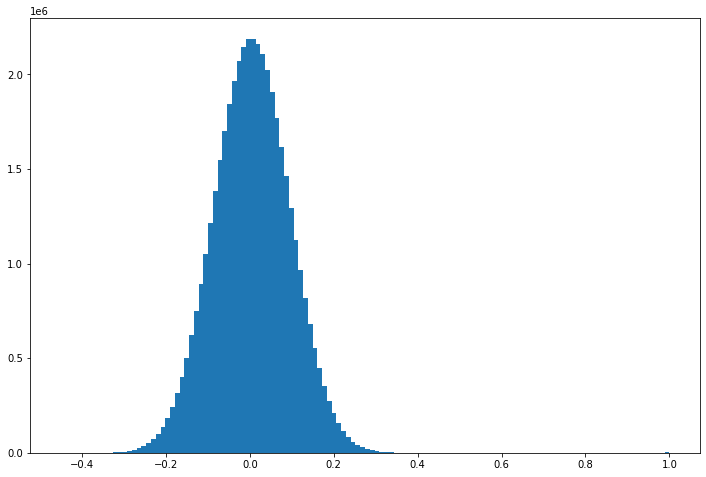

In [6]:
embedding_weights = palmtree.model.embedding
print(embedding_weights)
#Pair-wise Correlation
import pandas as pd

embedding_weights = pd.DataFrame(palmtree.model.embedding.token.weight.cpu().detach().numpy())

#for i in range(10):
#  print(np.linalg.norm(embedding_weights[i]))
print(np.corrcoef(embedding_weights[0], embedding_weights[1]))

df = pd.DataFrame(embedding_weights.transpose().corr().to_numpy().flatten())
df.columns = [""]
df.hist(bins=128, grid=False, figsize=(12,8))

## Pairwise Correlation(From Timothy's Notebook)

In [12]:
embedding_weights = palmtree.model.embedding.token.weight.cpu().detach().numpy()
df = pd.DataFrame(np.corrcoef(embedding_weights))

In [13]:
print(df)

          0         1         2     ...      6628      6629      6630
0     1.000000 -0.165081  0.004476  ...  0.025025  0.121227 -0.012780
1    -0.165081  1.000000 -0.032860  ... -0.152475 -0.065494  0.051710
2     0.004476 -0.032860  1.000000  ... -0.085538 -0.073666  0.154626
3     0.201307 -0.102769  0.204864  ... -0.015636  0.093186 -0.007344
4     0.191243 -0.169417  0.079684  ...  0.167005  0.118333  0.144841
...        ...       ...       ...  ...       ...       ...       ...
6626 -0.153602 -0.095749  0.072214  ...  0.129546  0.126123 -0.058529
6627  0.094828 -0.121430 -0.010681  ...  0.028345  0.055223  0.041075
6628  0.025025 -0.152475 -0.085538  ...  1.000000  0.041644 -0.065931
6629  0.121227 -0.065494 -0.073666  ...  0.041644  1.000000  0.004870
6630 -0.012780  0.051710  0.154626  ... -0.065931  0.004870  1.000000

[6631 rows x 6631 columns]


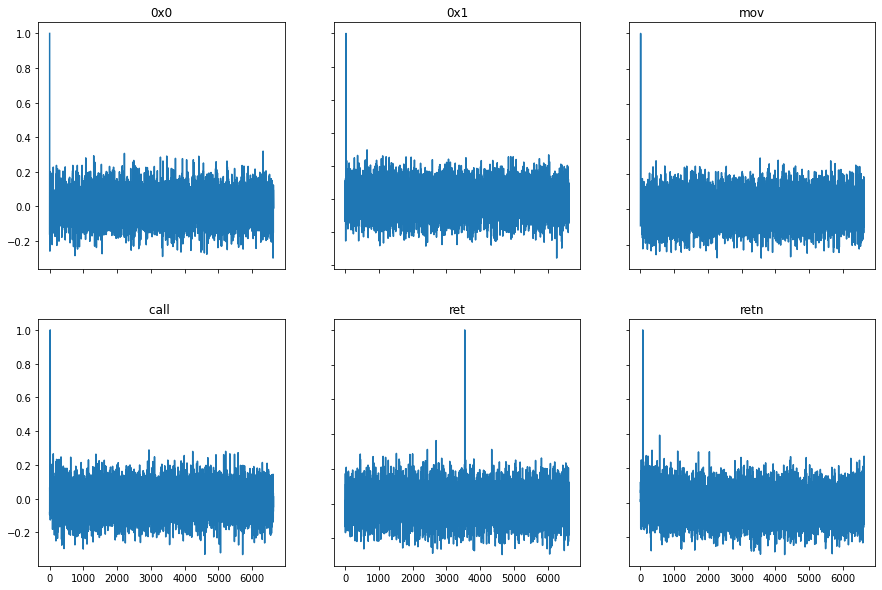

In [8]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

ax1.plot(df[0]), ax1.set_title("0x0")       # 0x0
ax2.plot(df[28]), ax2.set_title("0x1")      # 0x1
ax3.plot(df[5]), ax3.set_title("mov")       # mov
ax4.plot(df[18]), ax4.set_title("call ")    # call 
ax5.plot(df[3546]), ax5.set_title("ret")    # ret
ax6.plot(df[68]), ax6.set_title("retn")     # retn

for ax in fig.get_axes():
    ax.label_outer()  

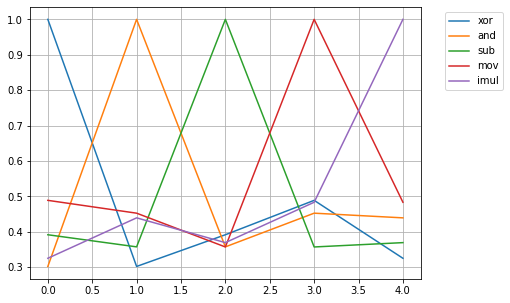

In [9]:
fig.clear()

# tokens have to be separated by spaces.
dataset = ["xor eax eax",
          "and 0x0 eax",
          "sub eax eax",
          "mov [eax] 0x0",
          "imul eax 0x0"]
output_tensor = palmtree.encode(dataset)

out = pd.DataFrame(np.corrcoef(output_tensor))
plt.figure(figsize=(7, 5))

plt.plot(out[0], label="xor")   # xor eax eax
plt.plot(out[1], label="and")   # and 0x0 eax
plt.plot(out[2], label="sub")   # sub eax eax
plt.plot(out[3], label="mov")   # mov [eax] 0x0
plt.plot(out[4], label="imul")  # imul eax 0x0

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

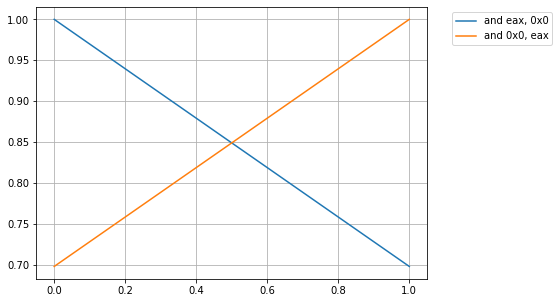

In [10]:
# tokens have to be separated by spaces.
dataset = ["and eax 0x0", 
           "and 0x0 eax"] # TODO: Change this, not valid x86
output_tensor = palmtree.encode(dataset)

out = pd.DataFrame(np.corrcoef(output_tensor))
plt.figure(figsize=(7, 5))

plt.plot(out[0], label="and eax, 0x0")   # and eax, 0x0
plt.plot(out[1], label="and 0x0, eax")   # and 0x0, eax

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

## Cosine Similarity (From Timothy's Notebook)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(embedding_weights)

In [17]:
print(cs)

[[ 1.0000002  -0.16153808  0.00197767 ...  0.01987678  0.11424257
  -0.009327  ]
 [-0.16153808  1.         -0.03501261 ... -0.15619208 -0.07051703
   0.05460465]
 [ 0.00197767 -0.03501261  0.9999999  ... -0.08146736 -0.06871215
   0.15172051]
 ...
 [ 0.01987678 -0.15619208 -0.08146736 ...  1.          0.05029183
  -0.07061237]
 [ 0.11424257 -0.07051703 -0.06871215 ...  0.05029183  1.0000001
  -0.00130744]
 [-0.009327    0.05460465  0.15172051 ... -0.07061237 -0.00130744
   0.9999999 ]]


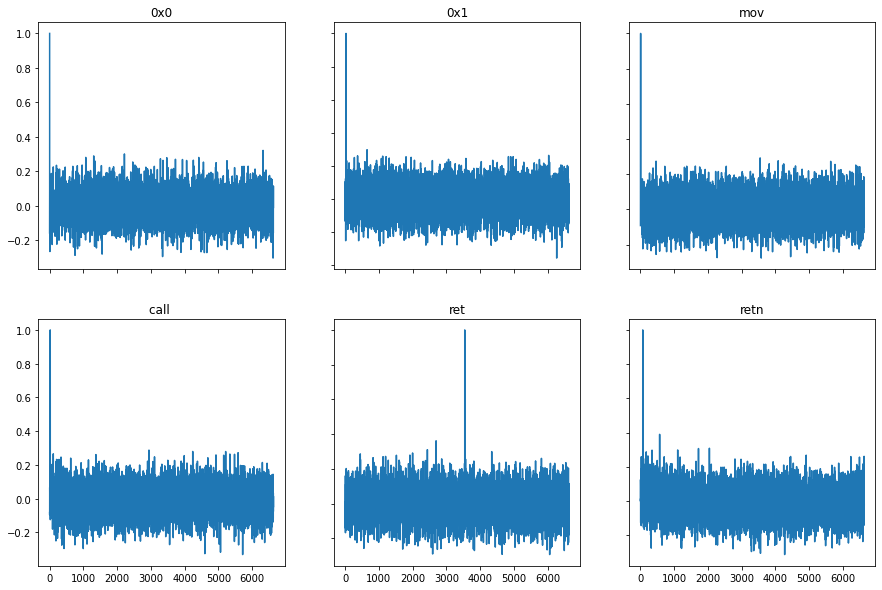

In [18]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,10))

ax1.plot(cs[0]), ax1.set_title("0x0")       # 0x0
ax2.plot(cs[28]), ax2.set_title("0x1")      # 0x1
ax3.plot(cs[5]), ax3.set_title("mov")       # mov
ax4.plot(cs[18]), ax4.set_title("call ")    # call 
ax5.plot(cs[3546]), ax5.set_title("ret")    # ret
ax6.plot(cs[68]), ax6.set_title("retn")     # retn

for ax in fig.get_axes():
    ax.label_outer()   

## Datasets Used for Intrinsic Evaluation

In [19]:
ground_truth_file = "intrinsic_eval/opcode.pkl"
with open(ground_truth_file, 'rb') as f:
    instruction_set = pickle.load(f)

type(instruction_set)
num_of_ins = 0
for ins in instruction_set:
  print(ins, len(instruction_set[ins]) ,instruction_set[ins])
  num_of_ins += len(instruction_set[ins])
print('number of instructions:' , num_of_ins)
print(type(instruction_set['BINOP']))

MOV 4206 {'mov,qword [ rbp - 0x330 ],rcx', 'mov,qword [ rsp + 0x30 ],r8', 'mov,rdi,r10', 'mov,rdx,qword [ rbp - 0x330 ]', 'mov,qword [ rsp + 0xf8 ],rax', 'mov,eax,dword [ ebp - 0x64 ]', 'mov,byte [ rsi + 0x21 ],0x0', 'mov,dword [ esp ],ecx', 'mov,r14,qword [ rbp - 0x300 ]', 'mov,byte [ rsi ],dil', 'mov,rbx,qword [ rsp + 0x30 ]', 'mov,qword [ rbp + 0x28 ],r14', 'mov,edi,dword [ ebp - 0x1c ]', 'mov,dword [ esp + 0x2c ],esi', 'mov,edi,0x3d', 'mov,dword [ r8 ],r10d', 'mov,dword [ esi + 0x4 ],ecx', 'mov,ebx,dword [ ebp - 0x28 ]', 'mov,rax,qword [ r12 + 0x18 ]', 'mov,rax,qword [ rsp + 0x88 ]', 'mov,edx,0x8d2', 'mov,esi,dword [ ebp - 0x24 ]', 'mov,dword [ rsi ],eax', 'push,rdi', 'push,dword [ edx ]', 'mov,edx,dword [ ecx + 0x8 ]', 'mov,ecx,dword [ r13 ]', 'mov,dword [ ebp - 0x7c ],eax', 'mov,qword [ rbp - 0x3f8 ],0x0', 'mov,dword [ esp + 0x24 ],eax', 'mov,ecx,0x8', 'mov,dword [ r13 ],r11d', 'mov,rsi,qword [ r12 + 0x30 ]', 'mov,dword [ ecx + 0x4 ],0x2', 'mov,rcx,qword [ rsp + 0x48 ]', 'mov,edi

## Outlier Detection Based on Opcode

In [ ]:
#Run Evaluation Based on Opcode
#!python intrinsic_eval/eval_opcode.py
import os
import random
import time
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from multiprocessing.dummy import Pool as ThreadPool
from torch import nn

from torch.autograd import Variable
import torch
import numpy as np
import eval_utils as utils
import re
import pickle

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


def find_outliner(embeddings):
    result = pairwise_distances(embeddings, embeddings, metric='cosine')
    result = result.sum(axis=0) #use min/max in stead of sum
    return np.argmax(result)

random.seed(time.time())
usable_model = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")
ground_truth_file = "./intrinsic_eval/opcode.pkl"

with open(ground_truth_file, 'rb') as f:
    instruction_set = pickle.load(f)

result = []


def process(it):
    global result
    acc = 0
    i = 0
    while i < 100:
        outliner, inliner = random.sample(instruction_set.keys(), 2)
        out_pos = random.randint(0, 4)
        outliner = random.sample(instruction_set[outliner], 1)[0]
        operand = outliner.split(',')
        operand.pop(0) # pop out the opcode and compare the operands
        inliner_lst = []
        counter = 0
        while len(inliner_lst) < 4:
            choice = random.choice(list(instruction_set[inliner]))
            choice_operand = choice.split(',')
            choice_operand.pop(0)
            if choice_operand == operand: # compare operands, operands must be the same in our set.
                inliner_lst.append(choice)
            else:
                counter = counter+1
            if counter >= 5000:
                break
        
        if len(inliner_lst) < 4:
            # print("fail, choose another outlier")
            continue
        else:
            inliner = inliner_lst   
            inliner.insert(out_pos, outliner)
            inliner = [i.replace(",", " ")for i in inliner]
            embd = usable_model.encode(inliner)

            otlr = find_outliner(embd)

            if otlr == out_pos:
                acc += 1

        i+=1
    result.append(acc/100)

pool = ThreadPool()
pool.map(process, range(20))
pool.close()
pool.join()


with open('op_palmtree.pkl', 'wb') as f:
    pickle.dump(result, f)

Loading Vocab ./palmtree/vocab
Vocab Size:  6631


In [ ]:
#Test results from the previous Run
output_file = "./op_palmtree.pkl"
with open(output_file, 'rb') as f:
    result_set = pickle.load(f)

print(result_set)

[0.85, 0.88, 0.89, 0.86, 0.85, 0.86, 0.9, 0.85, 0.85, 0.89, 0.89, 0.87, 0.91, 0.86, 0.9, 0.81, 0.9, 0.85, 0.85, 0.93]


In [ ]:
#Compute avg and SD
import statistics

avg = statistics.mean(result_set)
sd = statistics.pstdev(result_set)
print('Avg:', avg, 'Std Dev:',sd)

Avg: 0.8725 Std Dev: 0.027726341266023555


## Creating 50k Instructions sets for Deep Metric Learning

### Import Libraries and Load the PalmTree Model

In [ ]:
#Import Libraries and Load the PalmTree model
import os
import random
import time
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from multiprocessing.dummy import Pool as ThreadPool
from torch import nn, optim
from pytorch_metric_learning import losses

from torch.autograd import Variable
import torch
import numpy as np
import eval_utils as utils
import re
import pickle
import numpy as np

usable_model = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")

#Read the opcode.pkl file and initialize offsets for Instruction groups
opcode_group_file = "./intrinsic_eval/opcode.pkl"

with open(opcode_group_file, 'rb') as f:
    instruction_set = pickle.load(f)

instruction_groups = dict()

#print('instruction_set is a',type(instruction_set))
offset = 0
for ins in instruction_set:
  ins_list = instruction_set[ins]
  instruction_groups[ins] = []
  instruction_groups[ins].append(offset) #start_index
  instruction_groups[ins].append(len(ins_list)+offset-1) #end_index
  offset += len(ins_list)
#num_of_ins += len(instruction_set[ins])
#print('number of instructions:' , num_of_ins)


#instruction_groups keeps a mapping of an instruction category(i.e. MOV) and start & end indices in that category
for key, val in instruction_groups.items():
    print(key, val)

Loading Vocab ./palmtree/vocab
Vocab Size:  6631
MOV [0, 4205]
BINOP [4206, 5948]
CALL [5949, 5973]
CMP [5974, 7245]
JMP [7246, 7285]
SHIFT [7286, 7438]
CSET [7439, 7482]
CMOV [7483, 7674]
UNARY [7675, 7699]
FP [7700, 7702]


### Compute Embeddings and Save to FILE [SKIP if FILE exists]

In [ ]:
#Generate Embeddings for Instructions Grouped by Opcode, and pickle the embeddings [The Time Consuming Step]
#Skip This Block if the 'opcode_instructions_embeddings.pkl' file already EXISTS
embeddings_list = []

for ins in instruction_set:
  ins_list = instruction_set[ins]
  for each_ins in ins_list:
    #Get Embeddings for a single Instruction
    each_ins = each_ins.replace(","," ")
    list_of_ins = []
    list_of_ins.append(each_ins)
    embd_matrix = usable_model.encode(list_of_ins) #have to pass a list here
    embd = embd_matrix.flatten()
    embeddings_list.append(embd) 

#dump the list of embeddings to a pickle file for later use
with open('opcode_instructions_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings_list, f)


print("# of instructions in embeddings_list", len(embeddings_list))

# of instructions in embeddings_list 7703


### Load the Embeddings from pickle file and Analyze

In [ ]:
#Unpickle the embeddings, and check it out 
with open('opcode_instructions_embeddings.pkl', 'rb') as f:
    embeddings_list = pickle.load(f)

In [ ]:
#check the shape of the embeddings 
all_embeddings = np.array(embeddings_list)
print(all_embeddings.shape)
print('Sample Embedding:')
for i in range(0, 2):
  print(all_embeddings[i])

(7703, 128)
Sample Embedding:
[ 2.0181198  -0.18442148  0.69263     0.17008309  0.6840913  -0.35406137
  0.70562124 -1.5910772   0.9449552   0.34003386  1.1466148  -0.63672435
  0.5789013   2.6920881  -2.865258    0.25921062 -0.70942247 -3.6329727
 -0.04817278 -1.8118137   1.5820763   1.1608765   0.71244234  0.09097211
 -0.1559199  -0.46664882 -0.15689823 -2.2575383  -1.0361322   0.02805676
  2.3018367  -3.166022    2.4905047  -0.7749751  -0.57024974 -0.8849021
 -0.5631755   1.8907073   2.6089637  -0.24806944  0.55199313  1.803545
  1.8691963   0.26714334  0.7066637  -0.90934527  0.91643155 -0.25894493
 -1.5485952   1.5777568   0.16268638 -4.950685   -0.05052347 -0.04997034
 -0.7572683   1.4419914  -0.01089282  0.0933667  -0.88902617  0.01523621
 -1.34428     1.2103764  -1.1896513  -0.8089107  -0.5866373   4.1223106
 -1.6857036  -1.0293586   1.9868675   0.6021081  -1.5693285   0.4846755
 -0.31245637  0.6678586   1.5733904   1.7959249   0.5012343  -2.0667825
  1.8776032   0.0301013   1.

In [ ]:
#method which can get the instruction from instruction_set
#using the instruction_group key and index'
#Do We Really Need this?
def fetch_instruction(_index):

  for key, val in instruction_groups.items():
    start_index = instruction_groups[key][0]
    end_index = instruction_groups[key][1]
    if(_index>=start_index and _index<=end_index):
      idx = _index-start_index
      size = len(instruction_set[key])
      #print('Group:', key,"Index:", idx,"Size:",size)
      if(idx>=size):
        print("Error!")
        return ""
      return list(instruction_set[key])[idx]


#Testing fetch_instruction(_index) method
ins = fetch_instruction(7250)
print(ins)

jns,address


In [ ]:
#Randomly pick two instruction groups
#Pick 4 instructions from one group and 1 instruction from the Other [use dictionary instruction_groups for this purpose]
#put the outlier at the end
random.seed(time.time())
result_matrix = []

while (len(result_matrix) < 50000):
    outliner_key, inliner_key = random.sample(instruction_groups.keys(), 2)
    outliner_choice = random.randint(instruction_groups[outliner_key][0], instruction_groups[outliner_key][1]) #random.sample(instruction_set[outliner], 1)[0]
    #outliner_ins = fetch_instruction(outliner_key, outliner_choice)
    outlier_check_list = []
    counter = 0
    while len(outlier_check_list) < 4:
        inliner_choice = random.randint(instruction_groups[inliner_key][0], instruction_groups[inliner_key][1])#random.choice(list(instruction_set[inliner]))
        #inliner_ins = fetch_instruction(inliner_key, inliner_choice)        
        if inliner_choice not in outlier_check_list: #find a different instruction to insert to the set.
            outlier_check_list.append(inliner_choice)
        else:
            counter = counter+1
        if counter >= 100: #Give up after 100 attempts
            break

    if len(outlier_check_list) < 4:
        # print("fail, choose another outlier")
        continue
    else:
        outlier_check_list.append(outliner_choice)   
        result_matrix.append(outlier_check_list)

result_matrix = np.array(result_matrix)
print(result_matrix.shape)
#do this until 50,000 rows are created

(50000, 5)


In [ ]:
#Get the Embeddings for an insruction from the outlier_check_list
#Use Index from outlier_check_list
def GetInstructionEmbedding(embd_matrix, ins_index):
  size = embd_matrix.shape[0]
  if(size <= ins_index):
    print("Wrong Index!")
    return
  else:
    return embd_matrix[ins_index]


In [ ]:
# Embedding network with triplet loss training on the 50,000 samples generated
from pytorch_metric_learning import losses, reducers

class Embedding(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Embedding, self).__init__()

    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.l3 = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, triplets):

    out = self.l1(triplets)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)

    return out

# Begin training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Embedding(128, 256, 128).to(device)
learning_rate = .001
reducer = reducers.MeanReducer()
criterion = losses.TripletMarginLoss(1.2, reducer, triplets_per_anchor='all')
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=.9)
epochs = 25
labels = torch.Tensor([0, 0, 0, 0, 1])

train_data = result_matrix[0:500, :]

for epoch in range(epochs):
  
  for i, (p1, p2, p3, p4, outlier) in enumerate(train_data):
    p1 = GetInstructionEmbedding(all_embeddings, p1)
    p2 = GetInstructionEmbedding(all_embeddings, p2)
    p3 = GetInstructionEmbedding(all_embeddings, p3)
    p4 = GetInstructionEmbedding(all_embeddings, p4)
    outlier = GetInstructionEmbedding(all_embeddings, outlier)

    data_embeddings = torch.Tensor([p1, p2, p3, p4, outlier]).to(device)

    embeddings = model(data_embeddings)
    optimizer.zero_grad()
    loss = criterion(embeddings, labels)
    print("Loss iteration {}: {}".format(i, loss))

    loss.backward()
    optimizer.step()
    
#torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/PalmTree-Trained/model.pth")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Streaming output truncated to the last 5000 lines.
Loss iteration 0: 0.0
Loss iteration 1: 0.021416187286376953
Loss iteration 2: 0.0
Loss iteration 3: 0.0
Loss iteration 4: 0.0
Loss iteration 5: 0.0
Loss iteration 6: 0.0
Loss iteration 7: 0.0
Loss iteration 8: 0.08851194381713867
Loss iteration 9: 0.005589485168457031
Loss iteration 10: 0.0
Loss iteration 11: 0.0
Loss iteration 12: 0.0
Loss iteration 13: 0.0
Loss iteration 14: 0.0
Loss iteration 15: 0.0
Loss iteration 16: 0.0
Loss iteration 17: 0.013998985290527344
Loss iteration 18: 0.0
Loss iteration 19: 0.0
Loss iteration 20: 0.0
Loss iteration 21: 0.0
Loss iteration 22: 0.0
Loss iteration 23: 0.0
Loss iteration 24: 0.0
Loss iteration 25: 0.0
Loss iteration 26: 0.006699085235595703
Loss iteration 27: 0.0
Loss iteration 28: 0.0
Loss iteration 29: 0.023899495601654053
Loss iteration 30: 0.0
Loss iteration 31: 0.0
Loss iteration 32: 0.0
Loss iteration 33: 0.0
Loss iteration 34: 0.0
Loss iteration 35: 0.0
Loss iteration 36: 0.0
Loss it

In [ ]:
#This function is taken from the PalmTree author's Notebook
def find_outliner(embeddings):
    result = pairwise_distances(embeddings, embeddings, metric='cosine')
    result = result.sum(axis=0) #use min/max in stead of sum
    return np.argmax(result)

In [ ]:
#print instructions and check outliers from the result_matrix
def test_accuracy(start, finish, model, verbose=False):
  #Keep an accuracy score
  total = finish-start
  accurate = 0
  model.eval()
  with torch.no_grad():

    for i in range(start,finish):
      check_embeddings = []
      check_row = result_matrix[i]
      if(verbose == True):
        print('[',end="")
      for j in check_row:
        if(verbose == True):
          print(fetch_instruction(j),end="; ")
        check_embeddings.append(all_embeddings[j])
      #check_embeddings = torch.Tensor(check_embeddings).to("cuda:0")
      #embeddings = model(check_embeddings)
      #embeddings = embeddings.cpu().numpy()
      if(verbose == True):
        print(']', end='\t')
      result = find_outliner(check_embeddings)
      if(verbose == True):
        print('Outlier is at',result)
      if result == 4:
        accurate+=1

    #Print out accuracy
    accuracy = accurate/total*100
    print("Accuracy of Outlier Detection:",accuracy)

In [ ]:
#Testing the accuary of PalmTree model's Embeddings to detect outliers
#np.set_printoptions(threshold=np.inf)
start=500
finish=50000
test_accuracy(start, finish, model, False)
#print(result_matrix[start:finish])

Accuracy of Outlier Detection: 68.69090909090909


In [ ]:
# Using all_embeddings to create a list for the new metric learning embeddings
print(np.shape(all_embeddings))
metric_embeddings = np.empty([7703, 128])
with torch.no_grad():
  for i, vector in enumerate(all_embeddings):
    vector = torch.Tensor(vector).to("cuda:0")
    new_embedding = model(vector)
    new_embedding = new_embedding.cpu().numpy()
    metric_embeddings[i] = new_embedding

print(np.shape(metric_embeddings))
print(all_embeddings[0])
print(metric_embeddings[0])
np.savetxt('metric_embeddings.txt', metric_embeddings)

(7703, 128)
(7703, 128)
[ 2.0181198  -0.18442148  0.69263     0.17008309  0.6840913  -0.35406137
  0.70562124 -1.5910772   0.9449552   0.34003386  1.1466148  -0.63672435
  0.5789013   2.6920881  -2.865258    0.25921062 -0.70942247 -3.6329727
 -0.04817278 -1.8118137   1.5820763   1.1608765   0.71244234  0.09097211
 -0.1559199  -0.46664882 -0.15689823 -2.2575383  -1.0361322   0.02805676
  2.3018367  -3.166022    2.4905047  -0.7749751  -0.57024974 -0.8849021
 -0.5631755   1.8907073   2.6089637  -0.24806944  0.55199313  1.803545
  1.8691963   0.26714334  0.7066637  -0.90934527  0.91643155 -0.25894493
 -1.5485952   1.5777568   0.16268638 -4.950685   -0.05052347 -0.04997034
 -0.7572683   1.4419914  -0.01089282  0.0933667  -0.88902617  0.01523621
 -1.34428     1.2103764  -1.1896513  -0.8089107  -0.5866373   4.1223106
 -1.6857036  -1.0293586   1.9868675   0.6021081  -1.5693285   0.4846755
 -0.31245637  0.6678586   1.5733904   1.7959249   0.5012343  -2.0667825
  1.8776032   0.0301013   1.565723

# Proposal: Teaching Malware Analysis students
**Write proposal to help students do software reverse engingeering** 
*   Education, not research 
*   Help students

*   Give function students need to analyze
*   Help student understand function by itself
*   Ghidra can generate the C Code, can it compile?
*   Isolate, where it calls another function, replace with placeholder
 *   Do not symbolically call another function
*   CFG, go down path and then back up?
*   **Find out how to provide the different cases for the function**
*   **How to go from symbolic execution, go to higher level semantics. i.e determine cases and give examples**
*   Use symbion instead of placeholder, and use concrete execution and provide values
*   Target common problems, not complex issues
*   Use binaries from the malware book

# Proposal: NLP describe functions
*   Use Microsoft API DLL, find description form web or binary itself
 *   Create Dataset to learn
*   Given a new function, generate a Natural language description of the function    


Combine what we learn from PalmTree Analysis, and try to solve problems others have done but better

Use embeddings to encode a program

# Further Readings & References

**Papers to read**
*   Neutron: https://cybersecurity.springeropen.com/articles/10.1186/s42400-021-00070-0
*   Geometry of Bert: http://vigir.missouri.edu/~gdesouza/Research/Conference_CDs/IEEE_WCCI_2020/IJCNN/Papers/N-21493.pdf
* PalmTree: https://arxiv.org/pdf/2103.03809.pdf
* Blanket Execution: https://www.usenix.org/system/files/conference/usenixsecurity14/sec14-paper-egele.pdf 